## Tutorial 5: Newton-Raphson method
Calculating equilibrium composition from given free energies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

### Free energies
$$ g_s = (c_s - 0.5)^2 + 0.5c_s - 0.1 $$
$$ g_l = (c_l - 0.1)^2 $$

In [2]:
c_s = sym.Symbol('c_s')
c_l = sym.Symbol('c_l')

In [3]:
g_s = (c_s - 0.5)**2 + 0.5*c_s - 0.1
g_l = (c_l - 0.1)**2
print("g_s = ", g_s)
print("g_l = ", g_l)
print("g_s = ", g_s.expand())
print("g_l = ", g_l.expand())

g_s =  0.5*c_s + (c_s - 0.5)**2 - 0.1
g_l =  (c_l - 0.1)**2
g_s =  c_s**2 - 0.5*c_s + 0.15
g_l =  c_l**2 - 0.2*c_l + 0.01


### Plot free energies

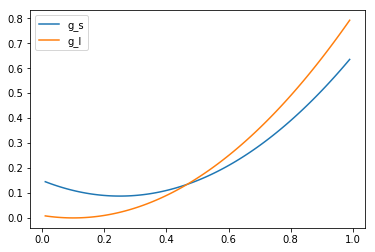

In [4]:
c = np.linspace(0.01, 0.99, 100)
# converting symbolic expression to function, just for plotting
g_s_func = sym.lambdify(c_s, g_s)
g_l_func = sym.lambdify(c_l, g_l)
plt.plot(c, g_s_func(c), label='g_s')
plt.plot(c, g_l_func(c), label='g_l')
plt.legend()
plt.show()

### Common tangent construction
To get equilibrium concentrations $ (c_s^{eq}, c_l^{eq}) $:
1. Equate the slopes:
$$ f_1 = \Big(\frac{\partial g_s}{\partial c}\Big)_{c_s^{eq}} - \Big(\frac{\partial g_l}{\partial c}\Big)_{c_l^{eq}} = 0 $$
2. Equate the intercept:
$$ f_2 = \Big[g_s - c_s^{eq}\Big(\frac{\partial g_s}{\partial c}\Big)_{c_s^{eq}}\Big] - \Big[g_l - \Big(c_l^{eq}\frac{\partial g_l}{\partial c}\Big)_{c_l^{eq}}\Big] = 0 $$

In [5]:
df_s = sym.diff(g_s, c_s)
df_l = sym.diff(g_l, c_l)
int_s = g_s - c_s*df_s
int_l = g_l - c_l*df_l
f1 = df_s - df_l
f2 = int_s - int_l

In [6]:
print("f1 = ", f1)
print("f1 = ", f1.simplify())
print("f2 = ", f2)
print("f2 = ", f2.simplify())

f1 =  -2*c_l + 2*c_s - 0.3
f1 =  -2*c_l + 2*c_s - 0.3
f2 =  c_l*(2*c_l - 0.2) - c_s*(2*c_s - 0.5) + 0.5*c_s - (c_l - 0.1)**2 + (c_s - 0.5)**2 - 0.1
f2 =  1.0*c_l**2 - 1.0*c_s**2 + 0.14


In [7]:
sym.diff(f2, c_l)

2*c_l

### Newton Raphson iterations
$$ \begin{bmatrix} x_s \\ x_l \end{bmatrix}_{i+1} = \begin{bmatrix} x_s \\ x_l \end{bmatrix}_{i} -  \begin{bmatrix} \dfrac{\partial f_1}{\partial x_s} & \dfrac{\partial f_1}{\partial x_l} \\ \dfrac{\partial f_2}{\partial x_s} & \dfrac{\partial f_2}{\partial x_l} \end{bmatrix}^{-1} \begin{bmatrix} f_1 \\ f_2 \end{bmatrix} $$

In [8]:
total_iterations = 10
c_guess = np.array( [0.1, 0.11] ) # (c_s, c_l)
c = c_guess
jacobian = np.array( [ [ sym.diff(f1, c_s), sym.diff(f1, c_l) ], [ sym.diff(f2, c_s), sym.diff(f2, c_l)] ] )
print("jacobian = \n", jacobian)

jacobian = np.array( [ [ sym.diff(f1, c_s).evalf(subs={ c_s:c[0], c_l:c[1] }), 
                            sym.diff(f1, c_l).evalf(subs={ c_s:c[0], c_l:c[1] }) ],
                        [ sym.diff(f2, c_s).evalf(subs={ c_s:c[0], c_l:c[1] }) , 
                         sym.diff(f2, c_l).evalf(subs={ c_s:c[0], c_l:c[1] })] ] )

jacobian = 
 [[2 -2]
 [-2*c_s 2*c_l]]


In [9]:
for i in range(total_iterations):
    jacobian = np.array( [ [ sym.diff(f1, c_s).evalf(subs={ c_s:c[0], c_l:c[1] }), 
                            sym.diff(f1, c_l).evalf(subs={ c_s:c[0], c_l:c[1] }) ],
                        [ sym.diff(f2, c_s).evalf(subs={ c_s:c[0], c_l:c[1] }) , 
                         sym.diff(f2, c_l).evalf(subs={ c_s:c[0], c_l:c[1] })] ] )
    jacobian = jacobian.astype(np.float64) # converting datatype to float64 format
    inv_jacobian = np.linalg.inv(jacobian)
    c = c - np.dot(inv_jacobian, np.array( [f1.evalf(subs={ c_s:c[0], c_l:c[1] }) , 
                                            f2.evalf(subs={ c_s:c[0], c_l:c[1] })  ] ) )
    print(i+1, c)

1 [-5.24500000000001 -5.39500000000001]
2 [0.541666666666726 0.391666666666726]
3 [0.541666666666667 0.391666666666667]
4 [0.541666666666667 0.391666666666667]
5 [0.541666666666667 0.391666666666667]
6 [0.541666666666667 0.391666666666667]
7 [0.541666666666667 0.391666666666667]
8 [0.541666666666667 0.391666666666667]
9 [0.541666666666667 0.391666666666667]
10 [0.541666666666667 0.391666666666667]


### Using built in non-linear solver fsolve

In [10]:
from scipy.optimize import fsolve
def equations(c):
    return ( f1.evalf(subs={ c_s:c[0], c_l:c[1] }), f2.evalf(subs={ c_s:c[0], c_l:c[1] }) )

c_eqbm = fsolve(equations, c_guess )
print(c_eqbm)

[0.54166667 0.39166667]
